In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2021-01-03 13:47:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  55.6MB/s    in 49s     

2021-01-03 13:47:52 (55.4 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [2]:
!gzip -d HIGGS.csv.gz

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
data = pd.read_csv('HIGGS.csv') # Read data from csv to a data frame

In [4]:
data

,1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00.1,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999994,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,1.858587,1.131711,-0.561694,0.000000,0.961000,0.671026,-0.178822,0.000000,1.177604,-0.097068,1.190680,3.101961,0.822136,0.766772,1.002191,1.061233,0.837004,0.860472,0.772484
10999995,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,1.002570,-0.636189,-0.367500,0.000000,0.650326,0.511733,-0.182705,0.000000,1.427826,-0.216995,1.049177,3.101961,0.826829,0.989809,1.029104,1.199679,0.891481,0.938490,0.865269
10999996,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,1.345027,0.993776,-1.298508,2.214872,1.252707,1.465673,1.262483,0.000000,0.419634,1.585235,1.713962,0.000000,0.337374,0.845208,0.987610,0.883422,1.888438,1.153766,0.931279
10999997,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,0.733136,0.356554,0.354436,2.214872,0.618363,-0.092672,-0.997614,0.000000,0.845596,1.399515,-1.313189,0.000000,0.838842,0.882890,1.201380,0.939216,0.339705,0.759070,0.719119


In [5]:
print(f"No. of columns: {len(data.columns)}\nNo. of rows: {len(data.index)}")

No. of columns: 29
No. of rows: 10999999


In [6]:
column_names = "lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb"
columns = column_names.split(",")

In [7]:
# Column 2 - 22: Kinematic Properties (Low Level features)
# Column 23 - 29: Functions of above 21 features (High Level features) 
data.columns = ['label'] + columns
data

,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999994,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,1.858587,1.131711,-0.561694,0.000000,0.961000,0.671026,-0.178822,0.000000,1.177604,-0.097068,1.190680,3.101961,0.822136,0.766772,1.002191,1.061233,0.837004,0.860472,0.772484
10999995,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,1.002570,-0.636189,-0.367500,0.000000,0.650326,0.511733,-0.182705,0.000000,1.427826,-0.216995,1.049177,3.101961,0.826829,0.989809,1.029104,1.199679,0.891481,0.938490,0.865269
10999996,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,1.345027,0.993776,-1.298508,2.214872,1.252707,1.465673,1.262483,0.000000,0.419634,1.585235,1.713962,0.000000,0.337374,0.845208,0.987610,0.883422,1.888438,1.153766,0.931279
10999997,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,0.733136,0.356554,0.354436,2.214872,0.618363,-0.092672,-0.997614,0.000000,0.845596,1.399515,-1.313189,0.000000,0.838842,0.882890,1.201380,0.939216,0.339705,0.759070,0.719119


In [13]:
# Custom class creation - Preparing data

class HIGGSDataset(Dataset):
  def __init__(self, csv_file, root):
    self.data = pd.read_csv(csv_file)
    self.root = root

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist() # Converts a torch tensor to a python list
    class_0_1 = self.data.iloc[idx, 0]
    values = self.data.iloc[idx, 1:]
    data_ = np.array(values)
    data_ = data_.astype('float').reshape(-1, 2)
    sample = {'class': class_0_1, 'data': data_}

    return sample

In [ ]:
# Instantiating dataset
Higgs_dataset = HIGGSDataset('HIGGS.csv', '/content/') # Using '/content/' for Google Colab

In [17]:
batch_size = 4 # No. of samples to load per batch
shuffle = True # Shuffle to ensure unbiasness in model
dataset_size = len(Higgs_dataset)
val_split = 0.2
split = int(np.floor(val_split * dataset_size))
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Split into train and valid sets
train_indices, valid_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(Higgs_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(Higgs_dataset, batch_size=batch_size, sampler=valid_sampler)

In [18]:
# Creating a Sequential model

Higgs_model = nn.Sequential(nn.Linear(28, 14),
                            nn.ReLU(),
                            nn.Linear(14, 7),
                            nn.ReLU(),
                            nn.Linear(7, 1),
                            nn.Sigmoid())

In [19]:
criterion = nn.BCELoss()
optimizer = optim.Adam(params=Higgs_model.parameters(), lr=0.001)

In [20]:
print(Higgs_model)

Sequential(
  (0): Linear(in_features=28, out_features=14, bias=True)
  (1): ReLU()
  (2): Linear(in_features=14, out_features=7, bias=True)
  (3): ReLU()
  (4): Linear(in_features=7, out_features=1, bias=True)
  (5): Sigmoid()
)


Training was terminated after 2 epochs below (using Ctrl + C)

In [ ]:
# Training

n_epochs = 10

train_losses = []
valid_losses = []
valid_loss_min = np.inf

for epoch in range(1, n_epochs):
  train_loss = 0
  valid_loss = 0

  # Training
  Higgs_model.train()
  #for data, target in train_loader:
  for i, batch in enumerate(train_loader, 0):
    #data, target = batch
    #print('Training going on...')
    data = batch['data']
    data = data.view(data.shape[0], -1)
    target = batch['class']
    target = target.type(torch.LongTensor)
    optimizer.zero_grad()
    output = Higgs_model(data.float())
    loss = criterion(output, target.float().unsqueeze(1))
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * data.size(0)
  
  # Validation
  Higgs_model.eval()
  for i, batch in enumerate(validation_loader, 0):
    #data, target = batch
    #print('Testing going on...')
    data = batch['data']
    data = data.view(data.shape[0], -1)
    target = batch['class']
    #target = target.type(torch.LongTensor)
    output = Higgs_model(data.float())
    loss = criterion(output, target.float().unsqueeze(1))
    valid_loss += loss.item() * data.size(0)

  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(validation_loader.sampler)
  
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'Epoch: {epoch}',
        f'Training Loss: {train_loss}',
        f'Valid Loss: {valid_loss}')
  
  if valid_loss < valid_loss_min:
    print(f'Validation Loss decreased: {valid_loss_min} --> {valid_loss}. Saving model...')
    torch.save(Higgs_model.state_dict(), 'higgs_model.pt')
    valid_loss_min = valid_loss

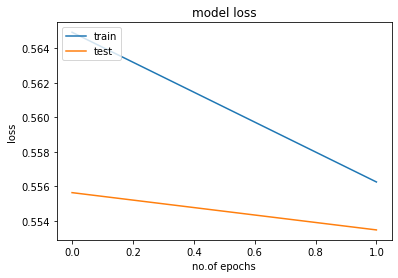

In [ ]:
# Plot loss

plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('no.of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Load the model

state_dict = torch.load('/content/higgs_model.pt')
print(state_dict.keys())

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [ ]:
# Model accuracy can be plotted by running this cell

Higgs_model.load_state_dict(state_dict)
accuracy = 0
accuracies = []
for i, batch in enumerate(validation_loader, 0):
  data = batch['data']
  data = data.view(data.shape[0], -1)
  output = Higgs_model(data.float())
  target = batch['class']
  target = target.type(torch.LongTensor)
  top_p, top_class = output.topk(1, dim=1)
  equals = top_class == target.view(*top_class.shape)
  accuracy += torch.mean(equals.type(torch.FloatTensor))
  accuracies.append(accuracy)

print(f'Accuracy: {accuracy / len(train_loader)}')

plt.plot(accuracies)
plt.title('model accuracy on test set')
plt.ylabel('accuracy')
plt.xlabel('no.of epochs')
plt.show()

In [ ]:
pip install plot-metric

In [ ]:
# ROC Curve visualization

for i, batch in enumerate(validation_loader, 0):
  data = batch['data']
  data = data.view(data.shape[0], -1)
  output = Higgs_model(data.float())
  target = batch['class']
  target = target.type(torch.LongTensor)

  break

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(output.round(), target, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()